In [ ]:
!pip install pygimli tetgen
!sudo apt install texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super

# 2D Refraction modelling and inversion

In [2]:
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.traveltime as tt
import matplotlib.pyplot as plt

from latex import latexify
latexify(columns=2)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Model setup

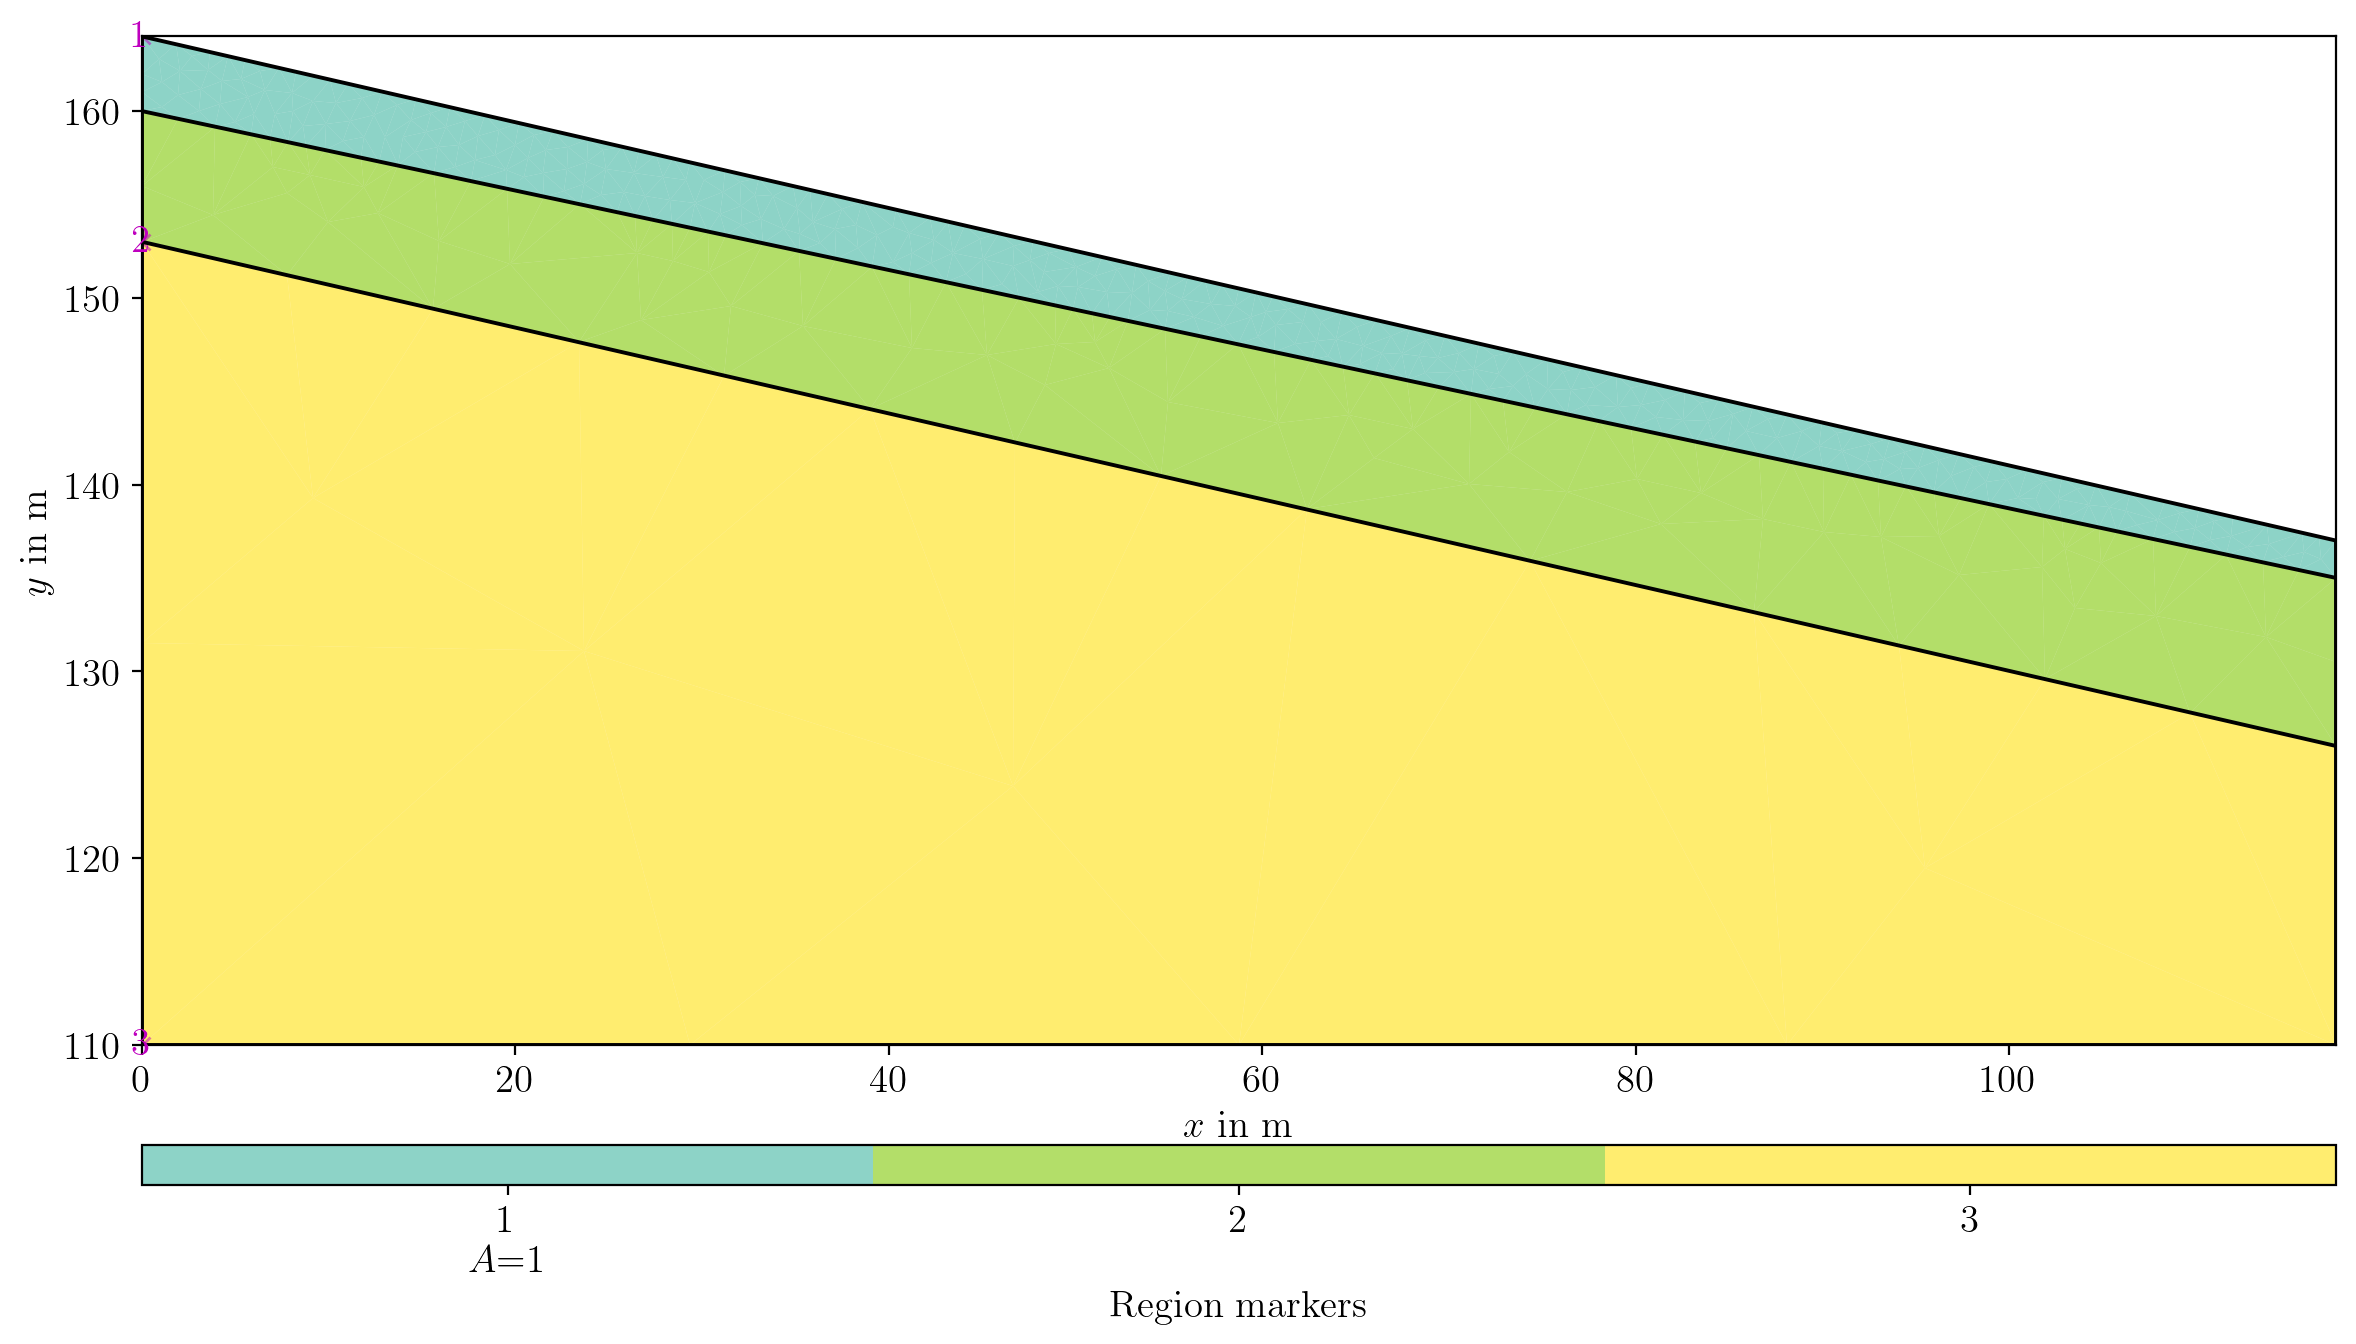

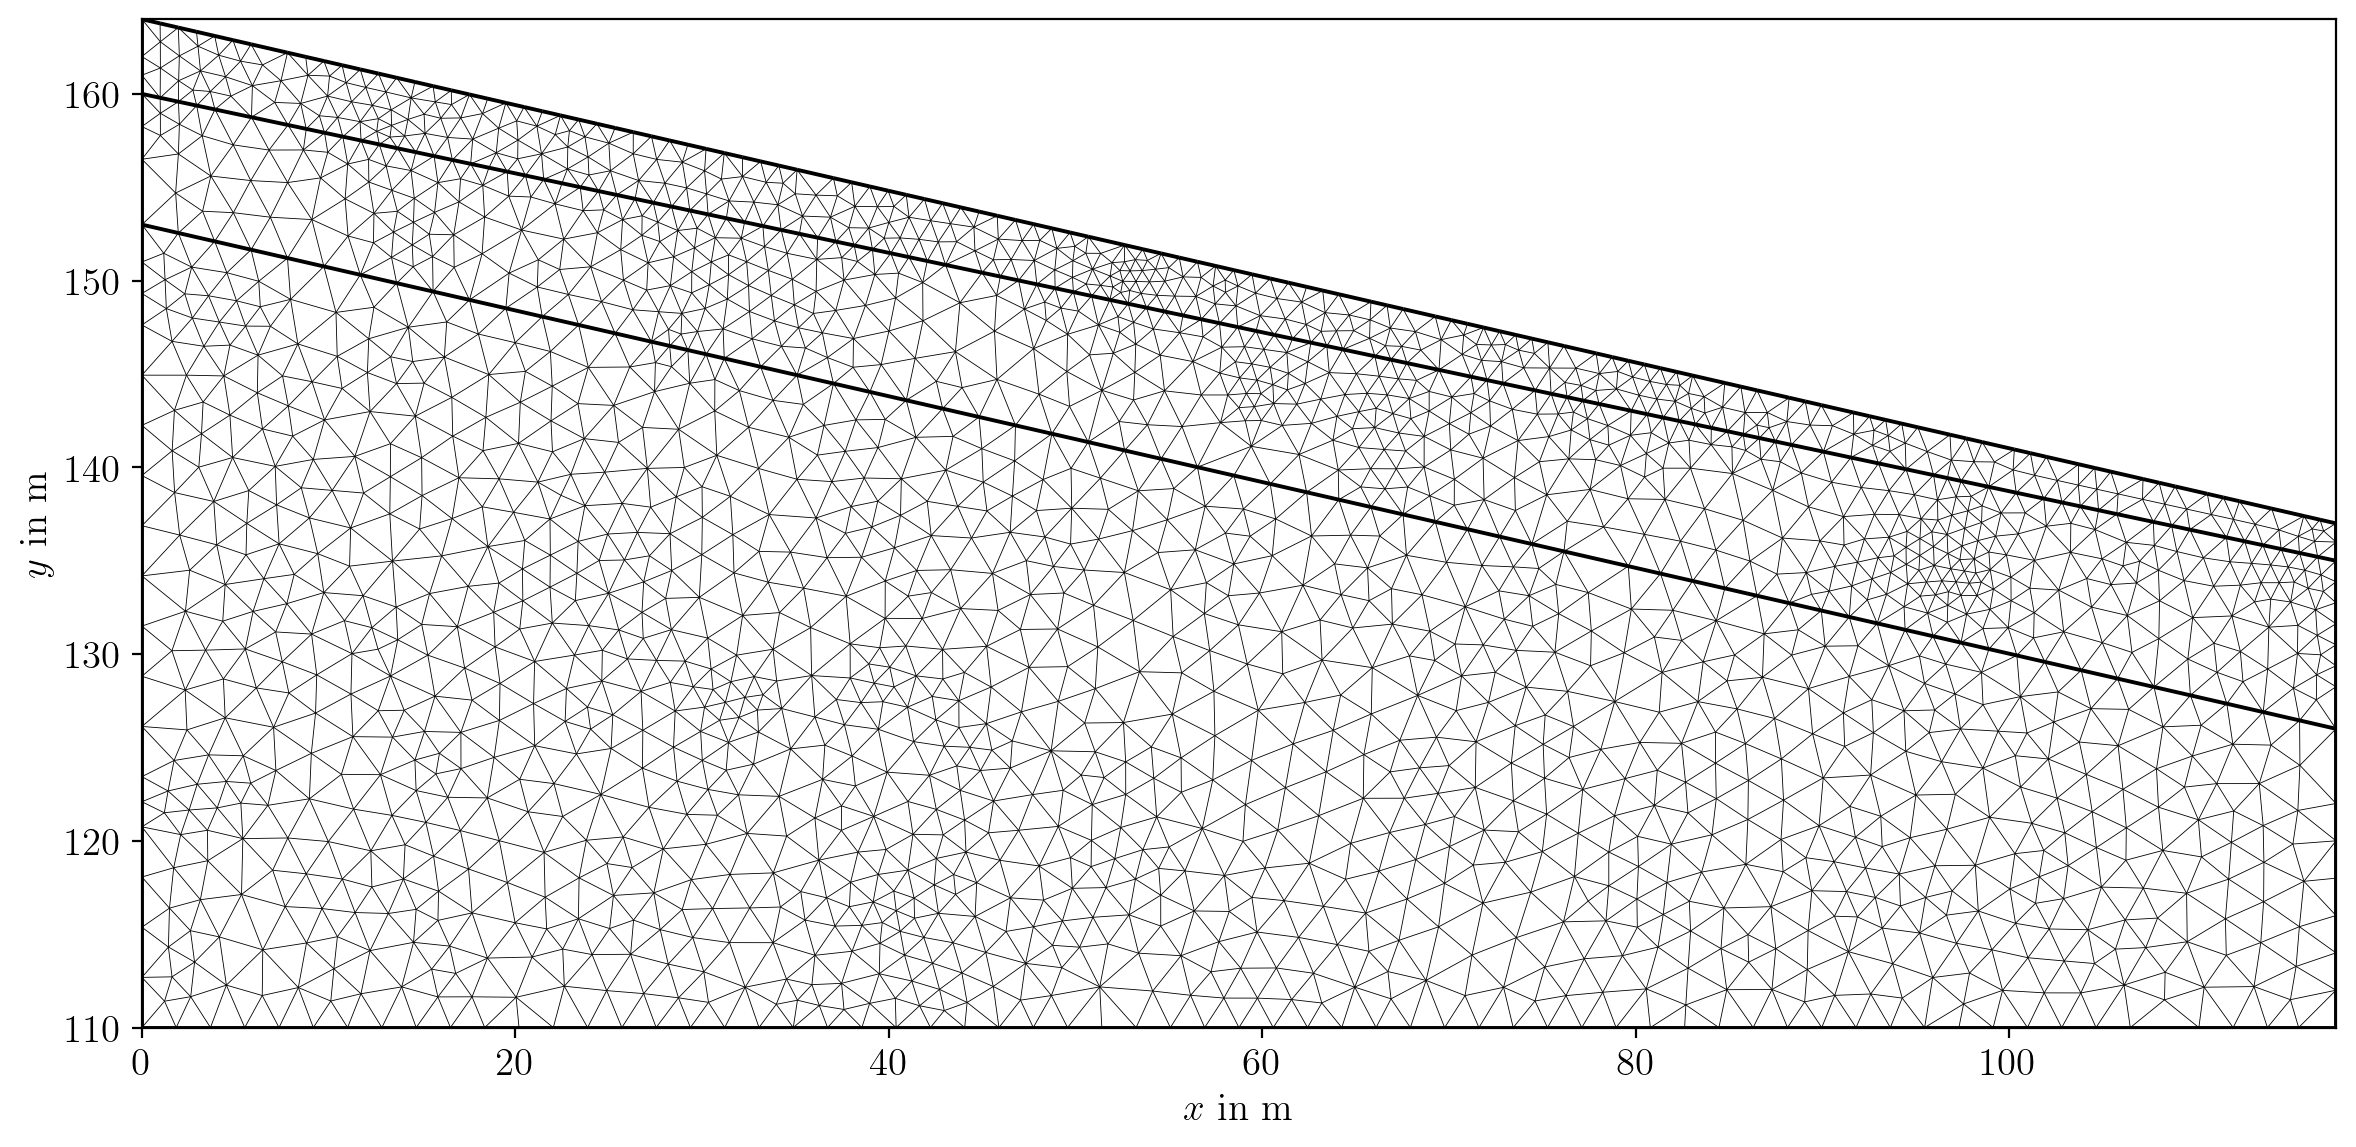

In [4]:
layer1 = mt.createPolygon([[0.0, 164], [117.5, 137], [117.5, 135], [0.0, 160]],
                          isClosed=True, marker=1, area=1)

layer2 = mt.createPolygon([[0.0, 153], [0.0, 160], [117.5, 135], [117.5, 126]],
                          isClosed=True, marker=2)

layer3 = mt.createPolygon([[0.0, 110], [0.0, 153], [117.5, 126], [117.5, 110]],
                          isClosed=True, marker=3)

geom = layer1 + layer2 + layer3

fig, ax = plt.subplots(figsize=(12, 8))
pg.show(geom, ax=ax)
plt.show()

mesh = mt.createMesh(geom, quality=34.3, area=3, smooth=[1, 10])
fig, ax = plt.subplots(figsize=(12, 8))
ax, _ = pg.show(mesh, ax=ax)
plt.show()

Next we define geophone positions and a measurement scheme, which consists of
shot and receiver indices.



In [7]:
numberGeophones = 48
sensors = np.linspace(0., 117.5, numberGeophones)
scheme = tt.createRAData(sensors, shotDistance=3)

# Adapt sensor positions to slope
slope = (137 - 164) / 117.5
pos = np.array(scheme.sensors())
for x in pos[:, 0]:
    i = np.where(pos[:, 0] == x)
    new_y = x * slope + 164
    pos[i, 1] = new_y

scheme.setSensors(pos)

## Synthetic data generation

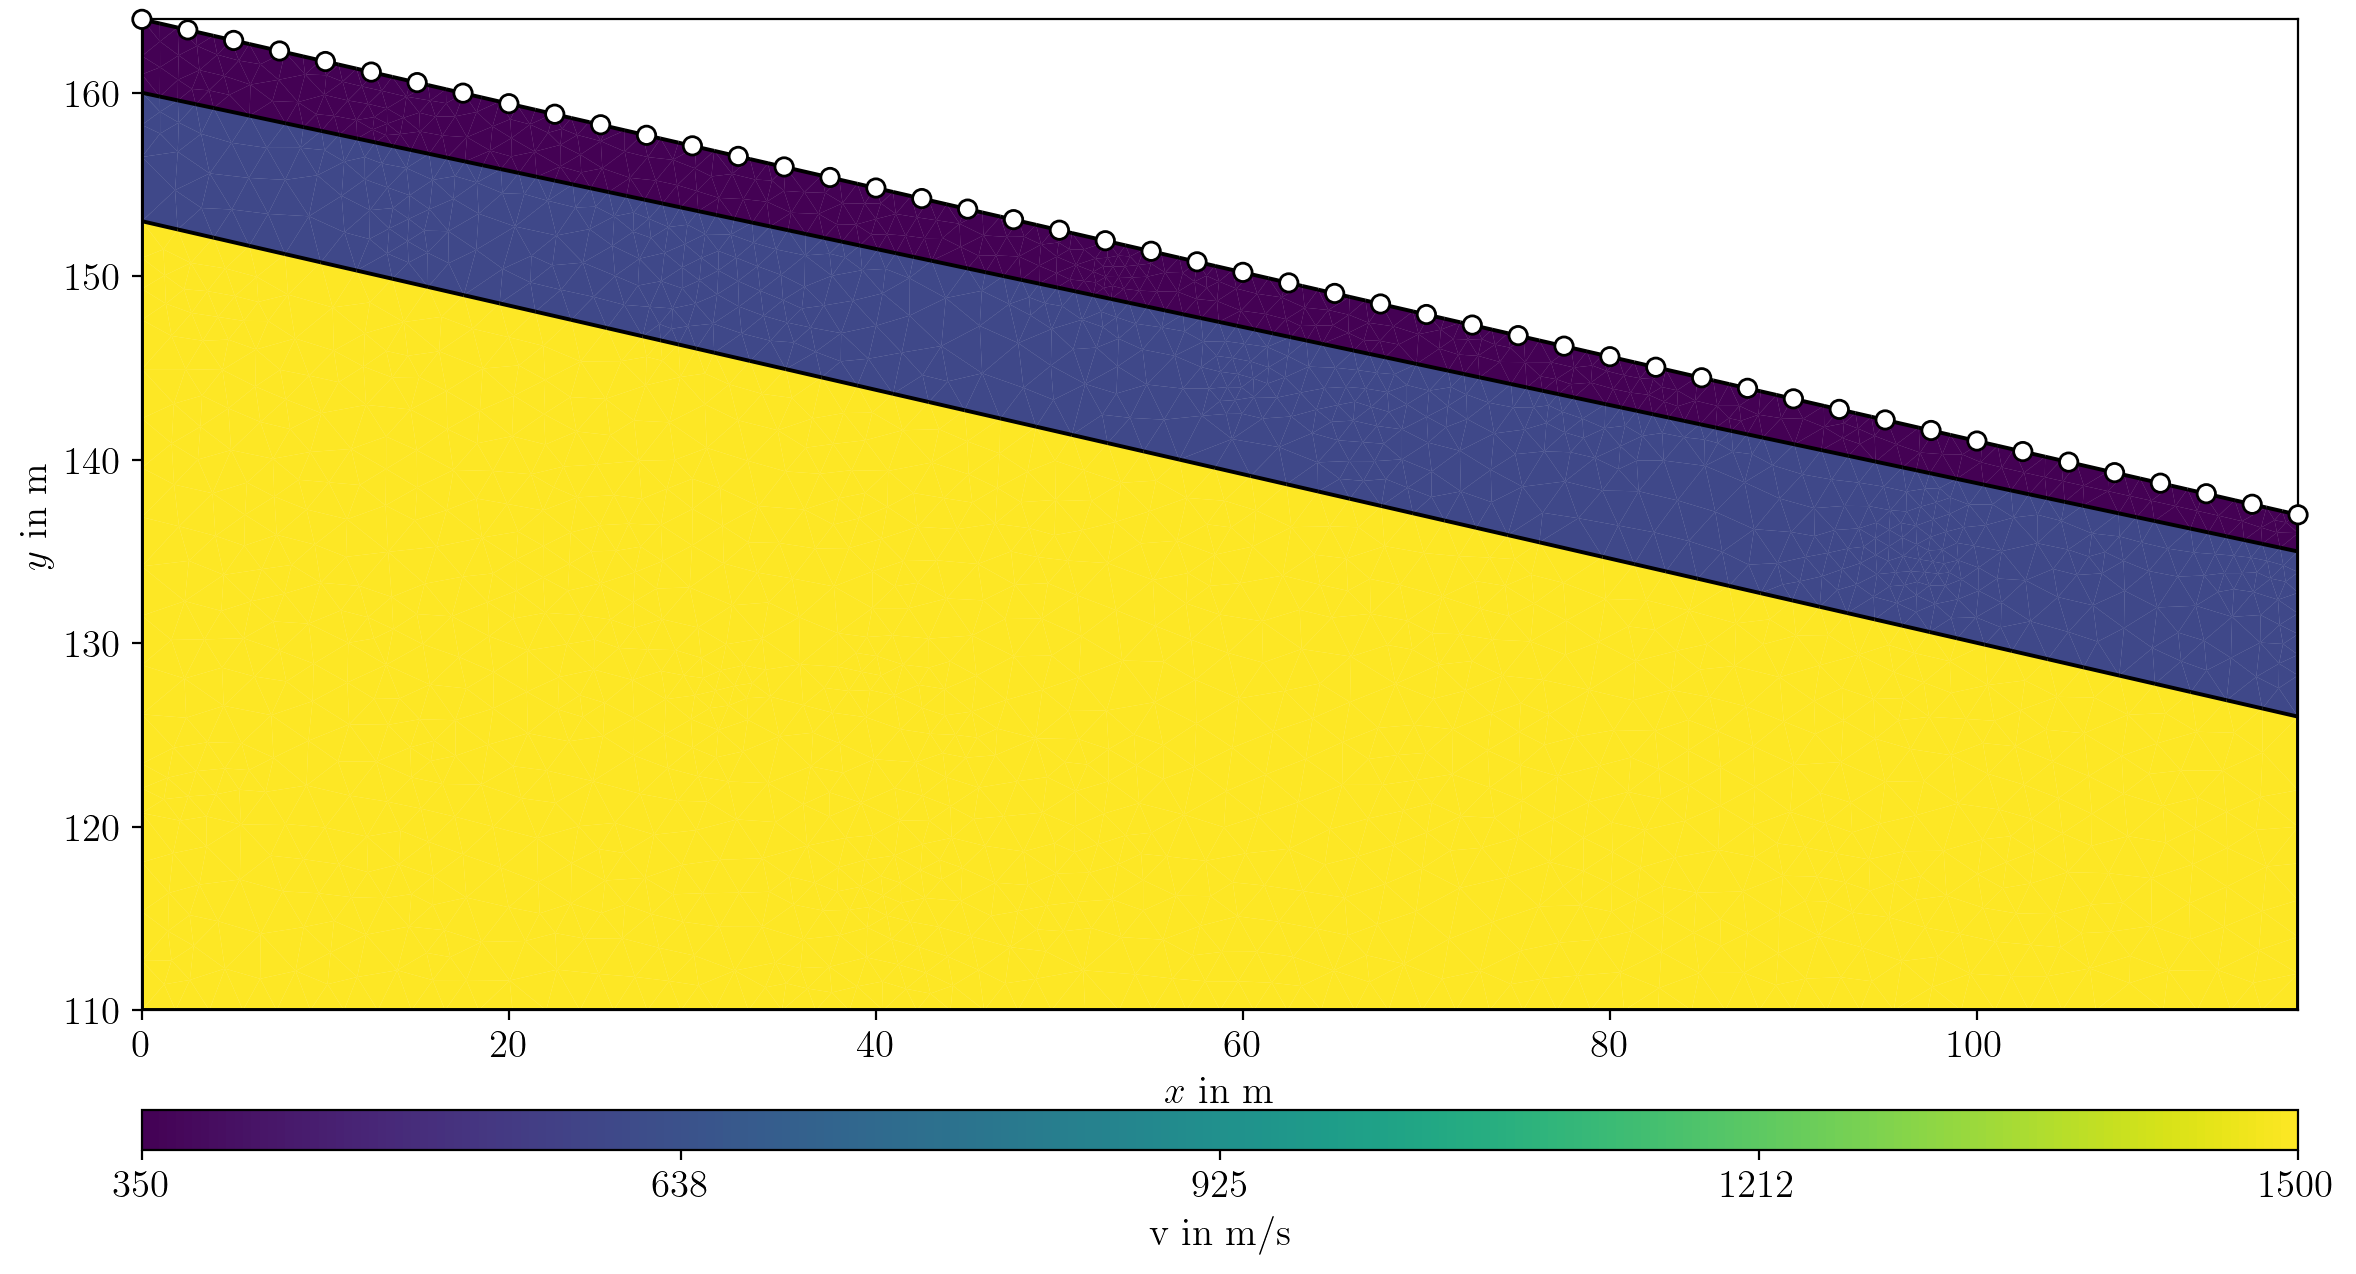

In [8]:
vp = np.array(mesh.cellMarkers())
vp[vp == 1] = 350
vp[vp == 2] = 600
vp[vp == 3] = 1500

fig, ax = plt.subplots(figsize=(12, 8))
ax, _ = pg.show(mesh, vp, colorBar=True, logScale=False, label='v in m/s', ax=ax)
pg.viewer.mpl.drawSensors(ax, scheme.sensors(), diam=1.0,
                         facecolor='white', edgecolor='black')

INFO:pyGIMLi:Creating refined mesh (secnodes: 2) to solve forward task.
31/10/25 - 12:12:59 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.


min/max t: 0.0066666666666666315 0.12081419102043212


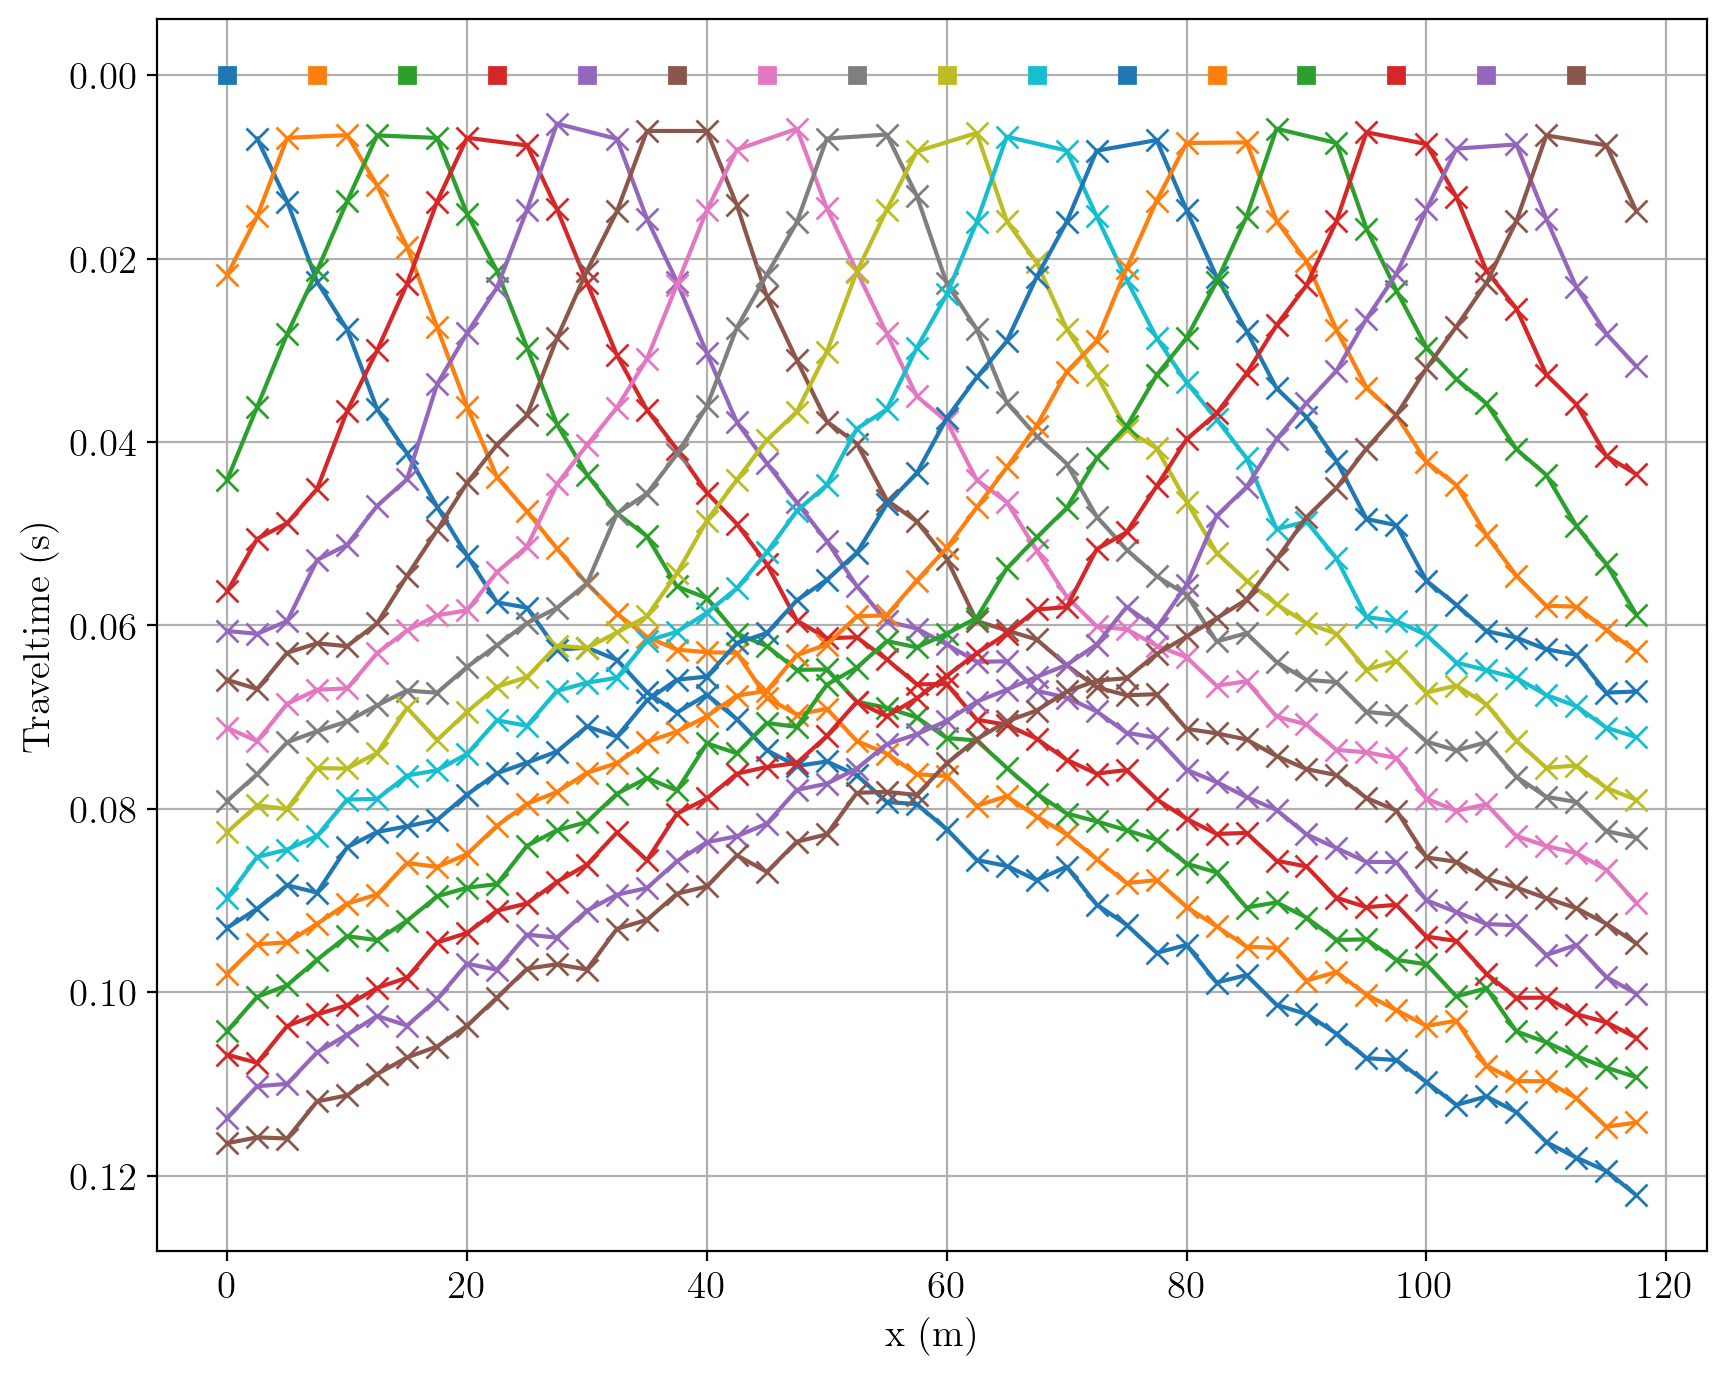

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
data = tt.simulate(slowness=1.0 / vp, scheme=scheme, mesh=mesh,
                   noiseLevel=0.001, noiseAbs=0.001, seed=1337, verbose=True)
tt.show(data, ax=ax)

## Inversion

In [10]:
mgr = tt.TravelTimeManager(data)
vest = mgr.invert(secNodes=2, paraMaxCellSize=15.0,
                  maxIter=10, verbose=True)
np.testing.assert_array_less(mgr.inv.inv.chi2(), 1.1)

INFO:pyGIMLi:Found 1 regions.
31/10/25 - 12:13:08 - pyGIMLi - INFO - Found 1 regions.
INFO:pyGIMLi:Found 1 regions.
31/10/25 - 12:13:08 - pyGIMLi - INFO - Found 1 regions.
INFO:pyGIMLi:Creating forward mesh from region infos.
31/10/25 - 12:13:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
INFO:pyGIMLi:Creating refined mesh (secnodes: 2) to solve forward task.
31/10/25 - 12:13:08 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.
INFO:pyGIMLi:Create gradient starting model. 500: 5000
31/10/25 - 12:13:08 - pyGIMLi - INFO - Create gradient starting model. 500: 5000
INFO:pyGIMLi:Created startmodel from forward operator:1254, min/max=0.000200/0.002000
31/10/25 - 12:13:08 - pyGIMLi - INFO - Created startmodel from forward operator:1254, min/max=0.000200/0.002000
INFO:pyGIMLi:Starting inversion.
31/10/25 - 12:13:08 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x7bf26726a020>
Data transformation: Identity transform
Model transformation: Logarithmic transform
min/max (data): 0.0053/0.12
min/max (error): 0.92%/19.08%
min/max (start model): 2.0e-04/0.002
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  216.74
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =    2.87 (dPhi = 98.48%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    1.25 (dPhi = 51.81%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    0.93 (dPhi = 21.35%) lam: 20.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.93)                   #
######################################

The manager also holds the method showResult that is used to plot the result.
Note that only covered cells are shown by default.
For comparison we plot the geometry on top.



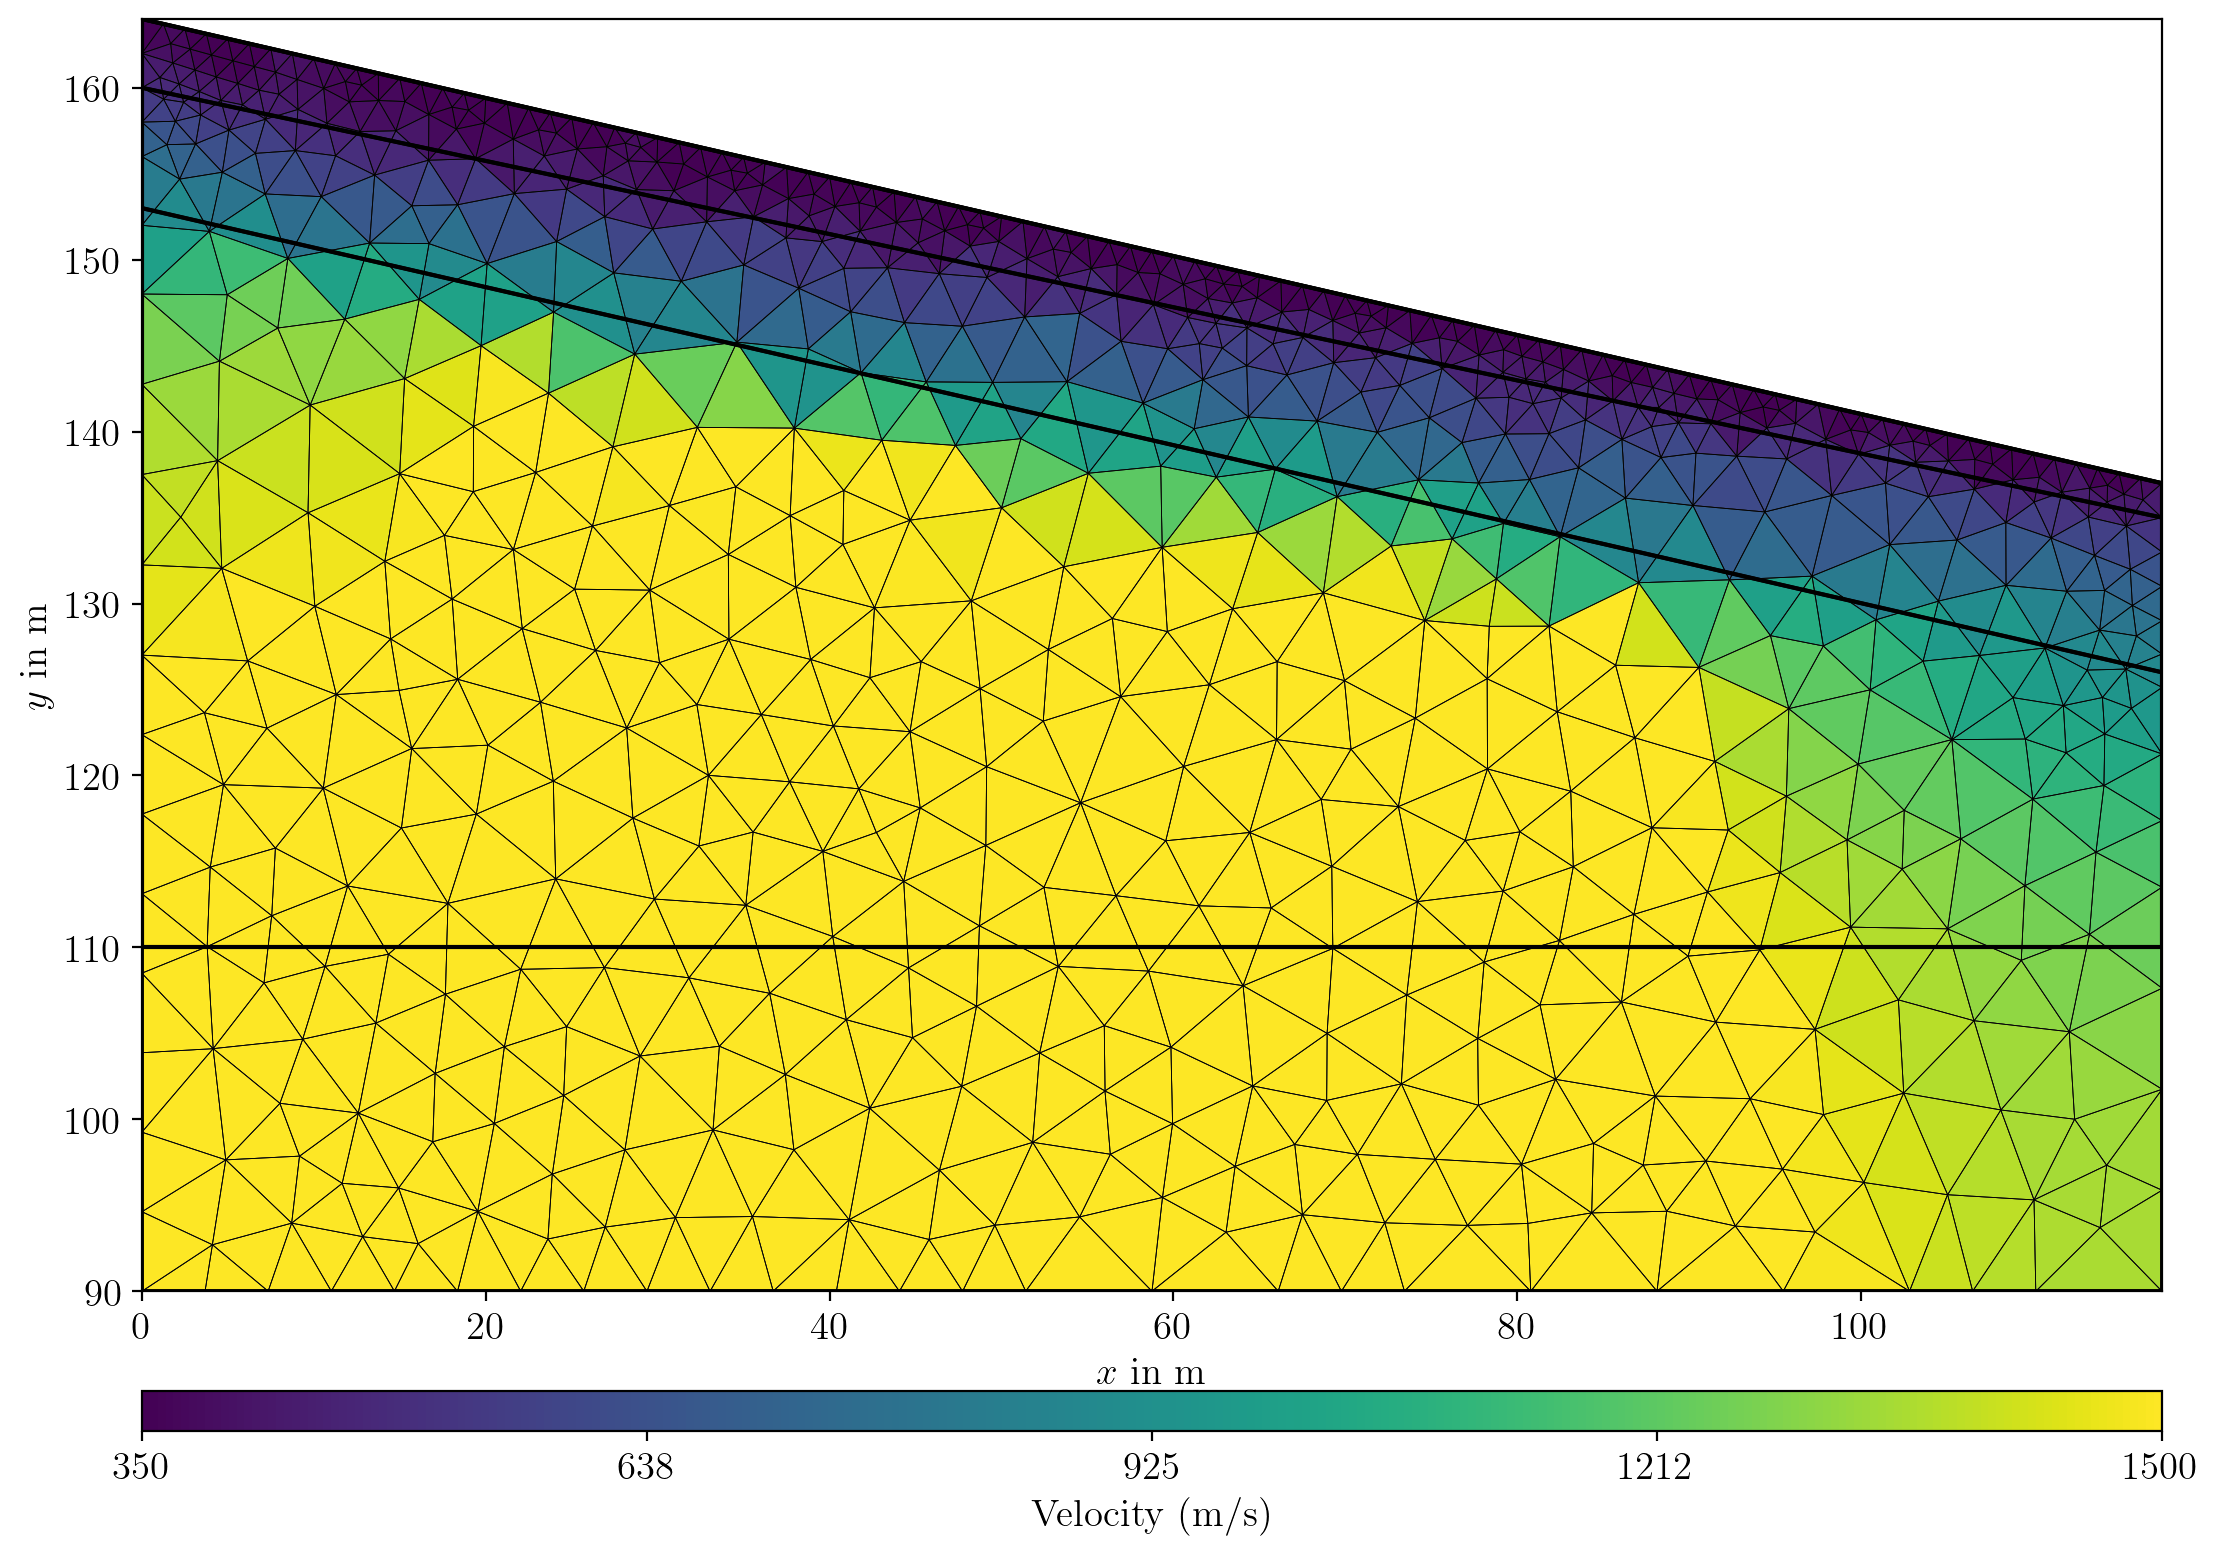

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
ax, _ = mgr.showResult(cMin=min(vp), cMax=max(vp), showMesh=True, logScale=False, ax=ax)
ax, _ = pg.show(geom, ax=ax, fillRegion=False, regionMarker=False)

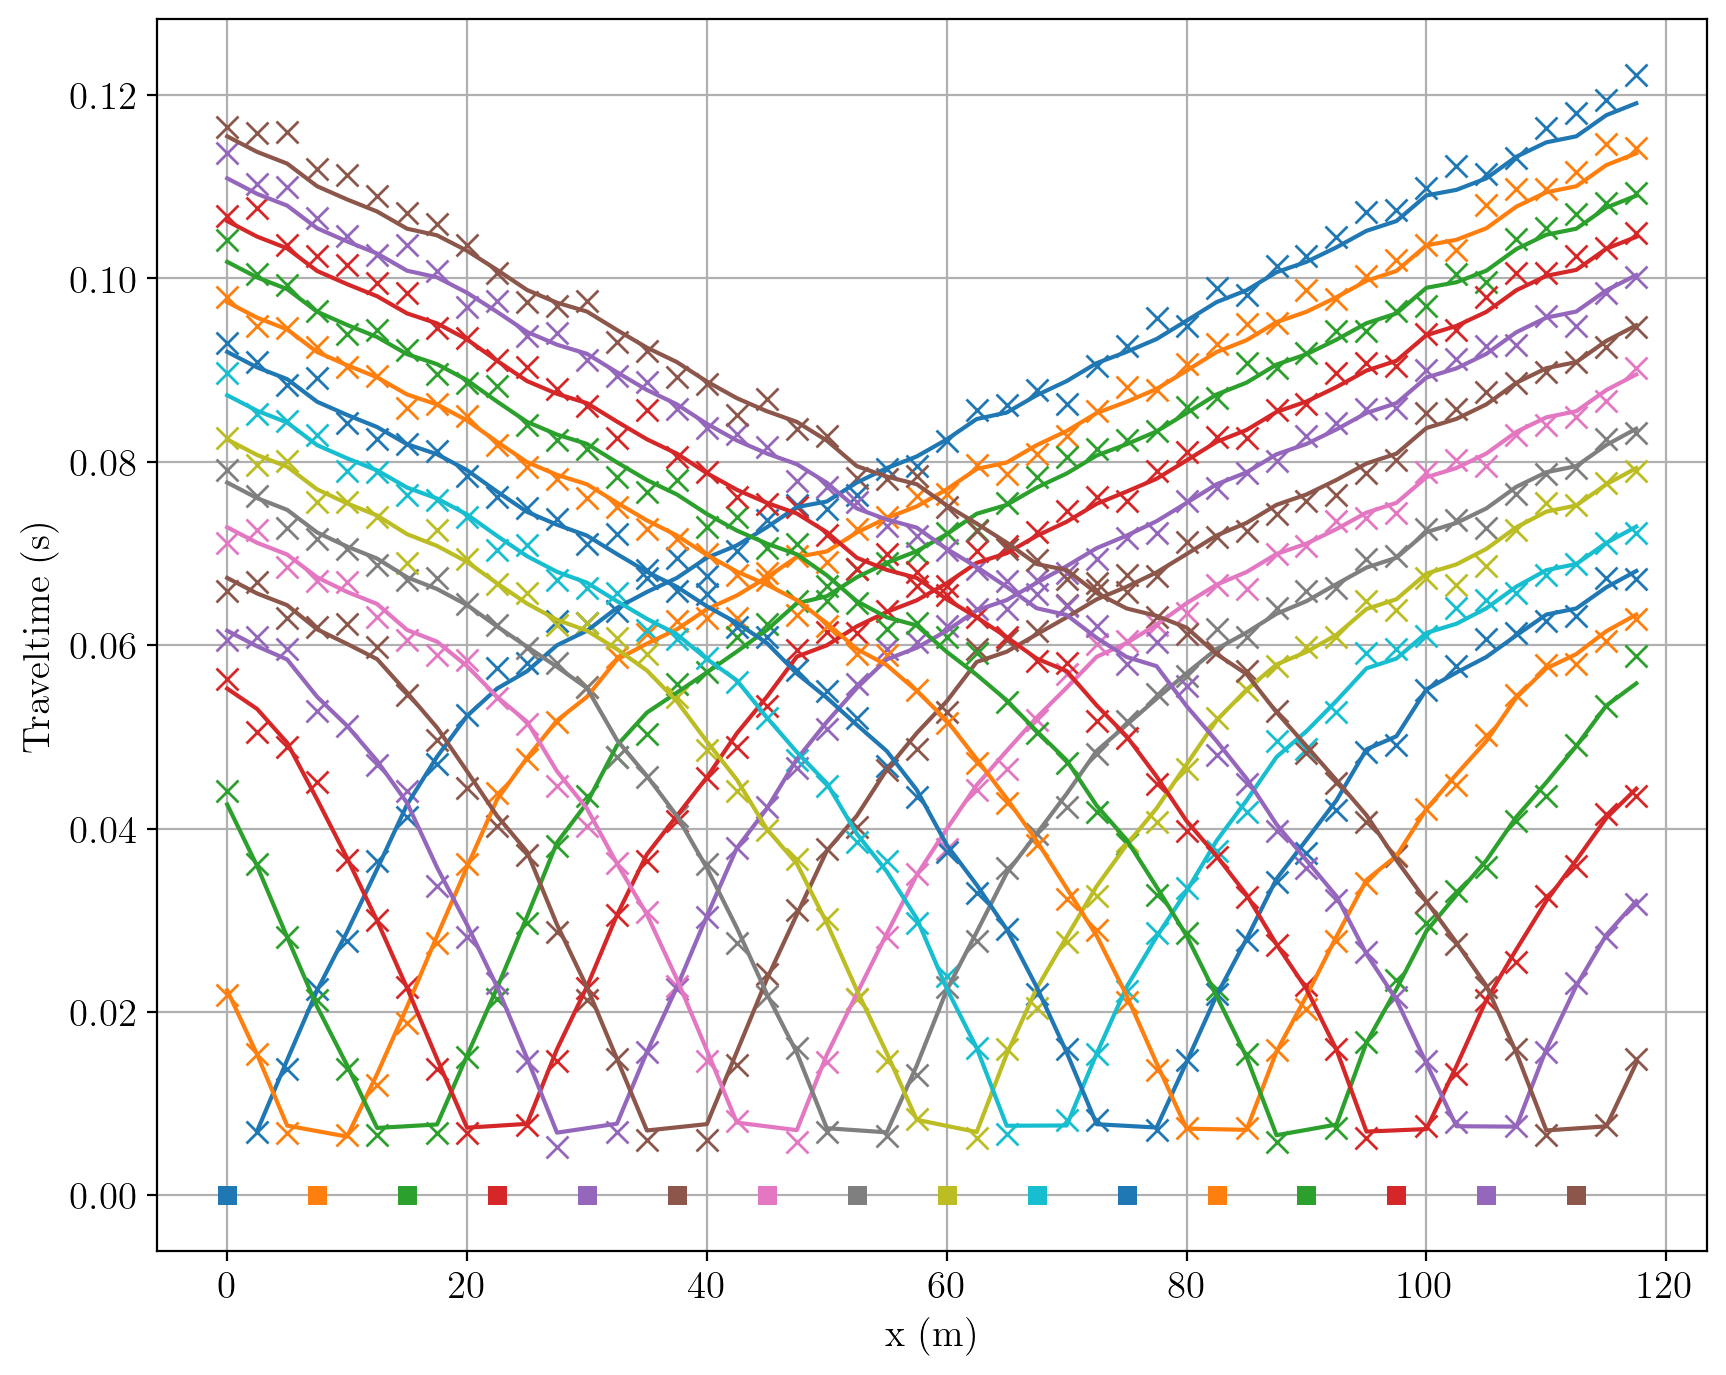

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
mgr.showFit(firstPicks=True, ax=ax)

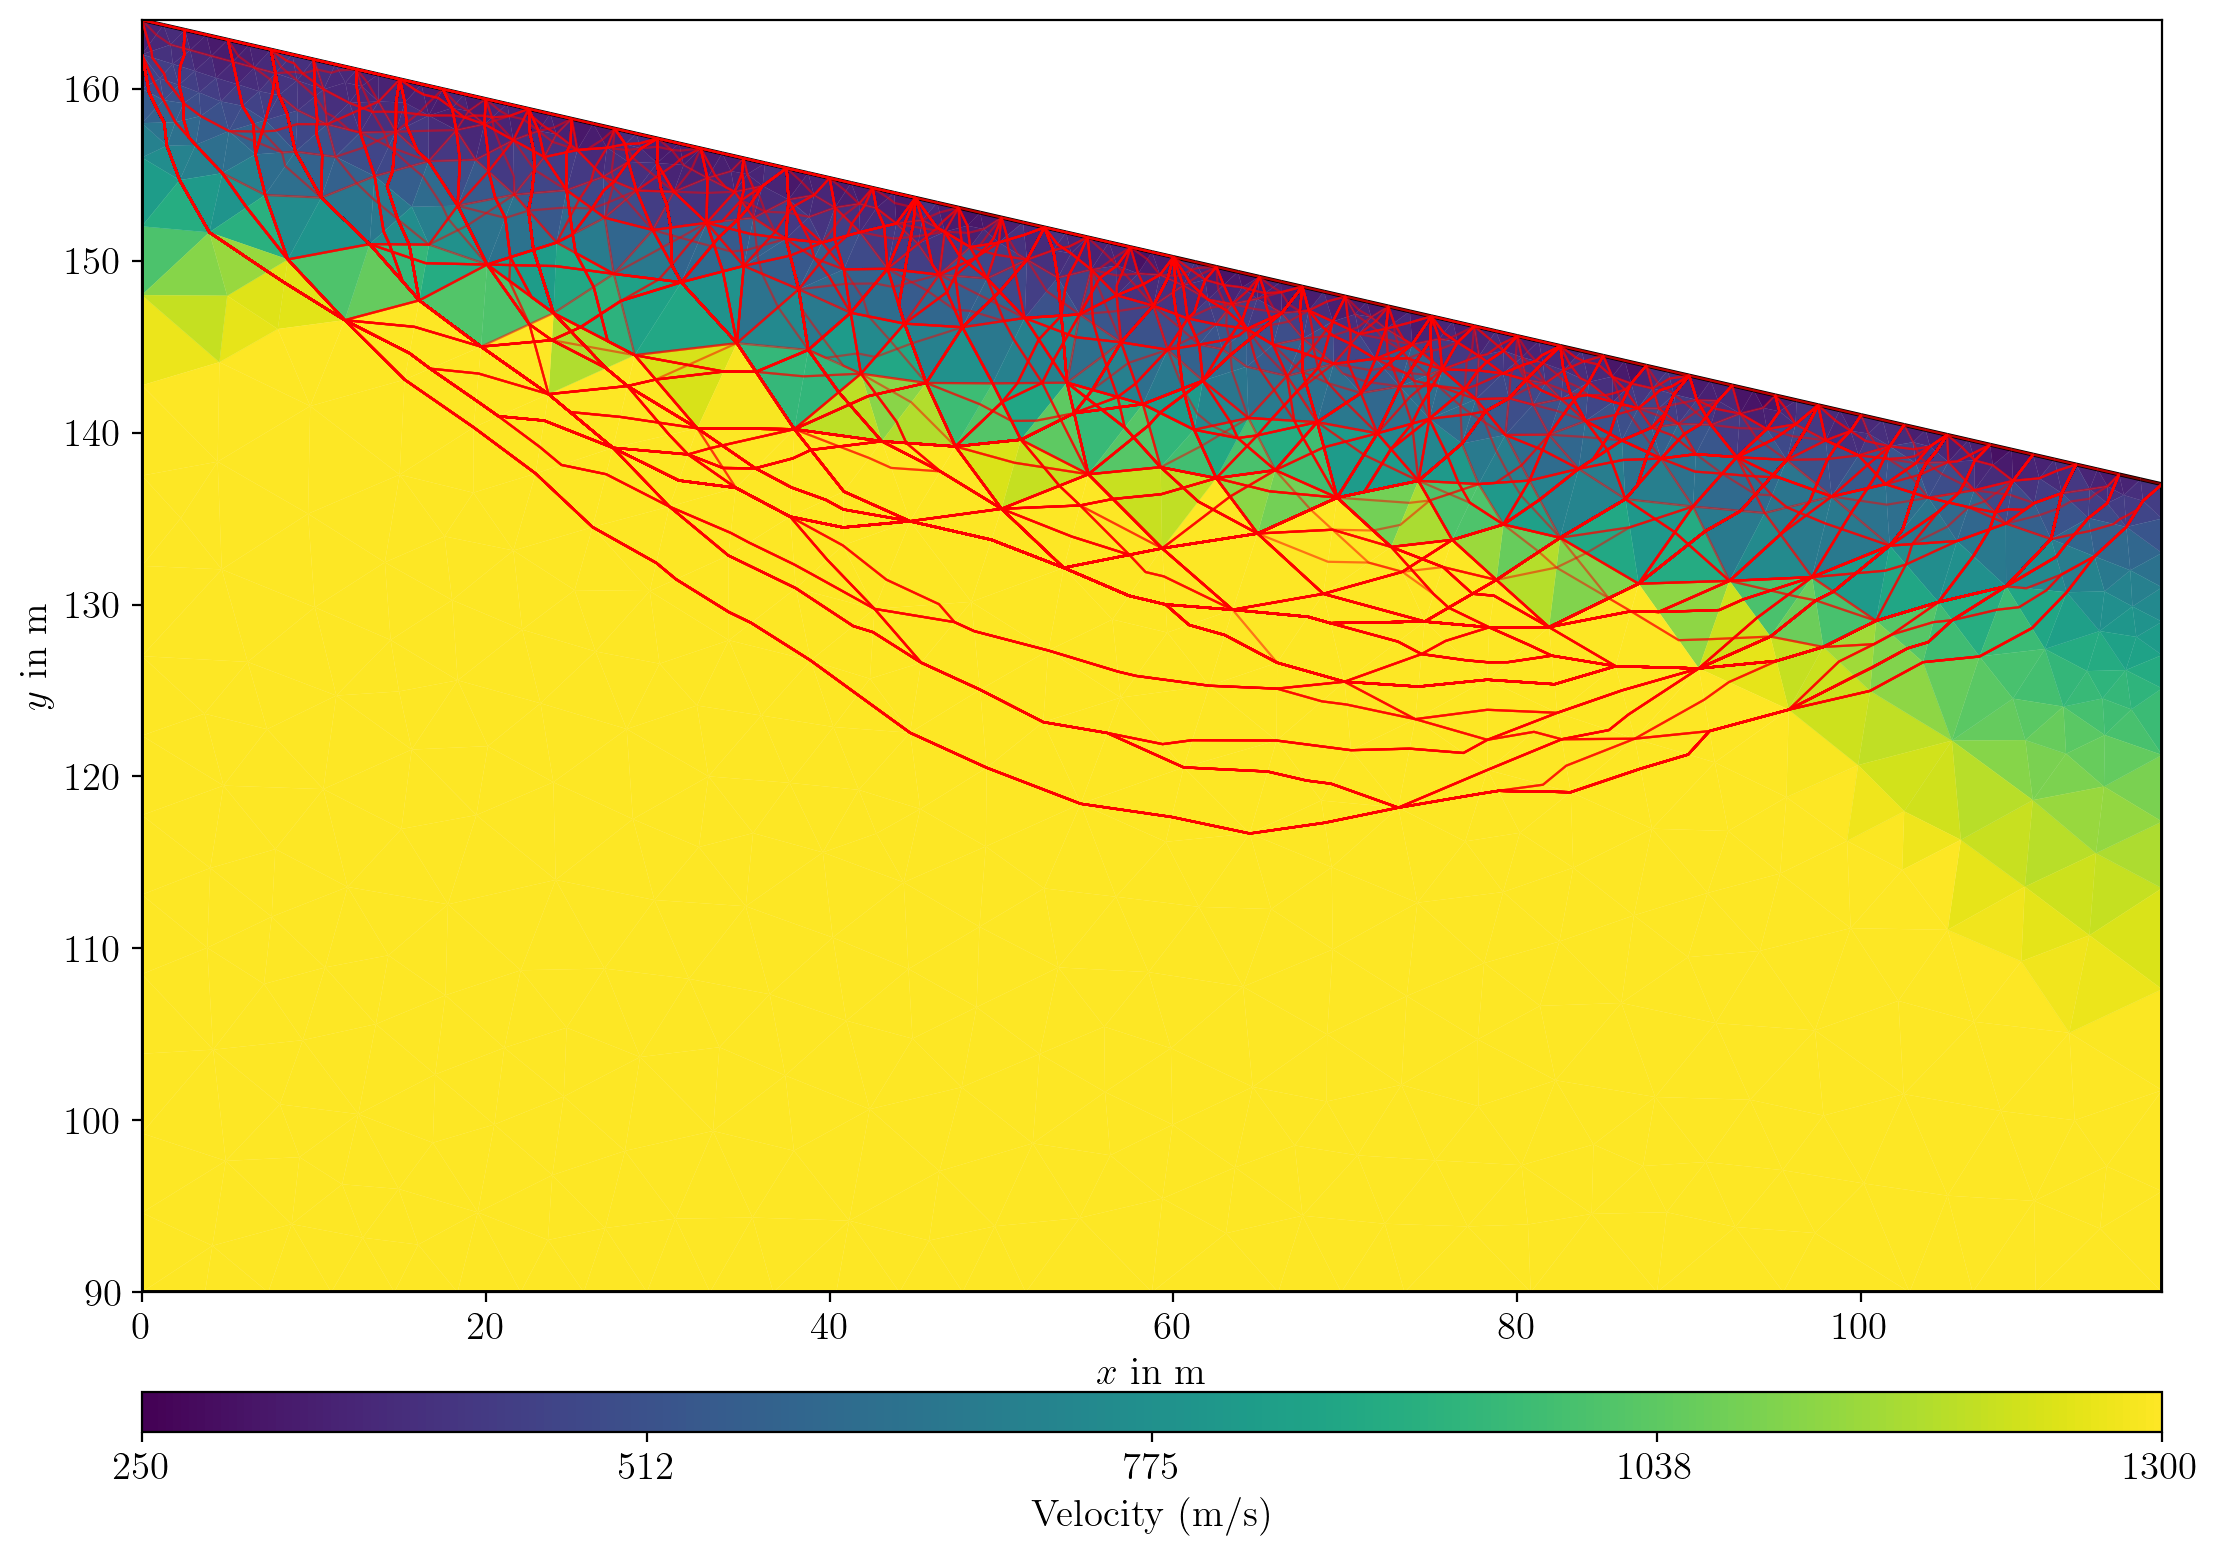

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
ax, cbar = mgr.showResult(logScale=False, cMin=250, cMax=1300, ax=ax)
rays = mgr.drawRayPaths(ax=ax, color="red",lw=0.8, alpha=0.5)